# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info_full = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [106]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               205378 non-null  float64
 1   ALTERSKATEGORIE_GROB   888340 non-null  float64
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            498903 non-null  float64
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             780025 non-nu

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
def print_data_info(data):
    print('Number of rows: {}'.format(data.shape[0]))
    print('Number of columns: {}'.format(data.shape[1]))


print_data_info(azdias)
azdias.head()

Number of rows: 891221
Number of columns: 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print_data_info(feat_info_full)
feat_info_full.head()

Number of rows: 85
Number of columns: 4


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
def parse_str_to_dict(str):
    result = {} # result dictionary to be returned at the end for replace function to use
    for i in str[1:-1].split(','):
        if i != '': # skip empty string
            try:
                result[int(i)] = np.nan # convert to int and set to NaN
            except:
                result[i] = np.nan # set to NaN if not int
    return result
# comvet feature info missing values to list
feat_info_full['missing_or_unknown'] = feat_info_full['missing_or_unknown'].apply(parse_str_to_dict)


In [6]:
# convert azdias missing values to NaN
for i, feat in enumerate(azdias.columns):
    azdias[feat] = azdias[feat].replace(feat_info_full['missing_or_unknown'][i])
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,NaN,3.0,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

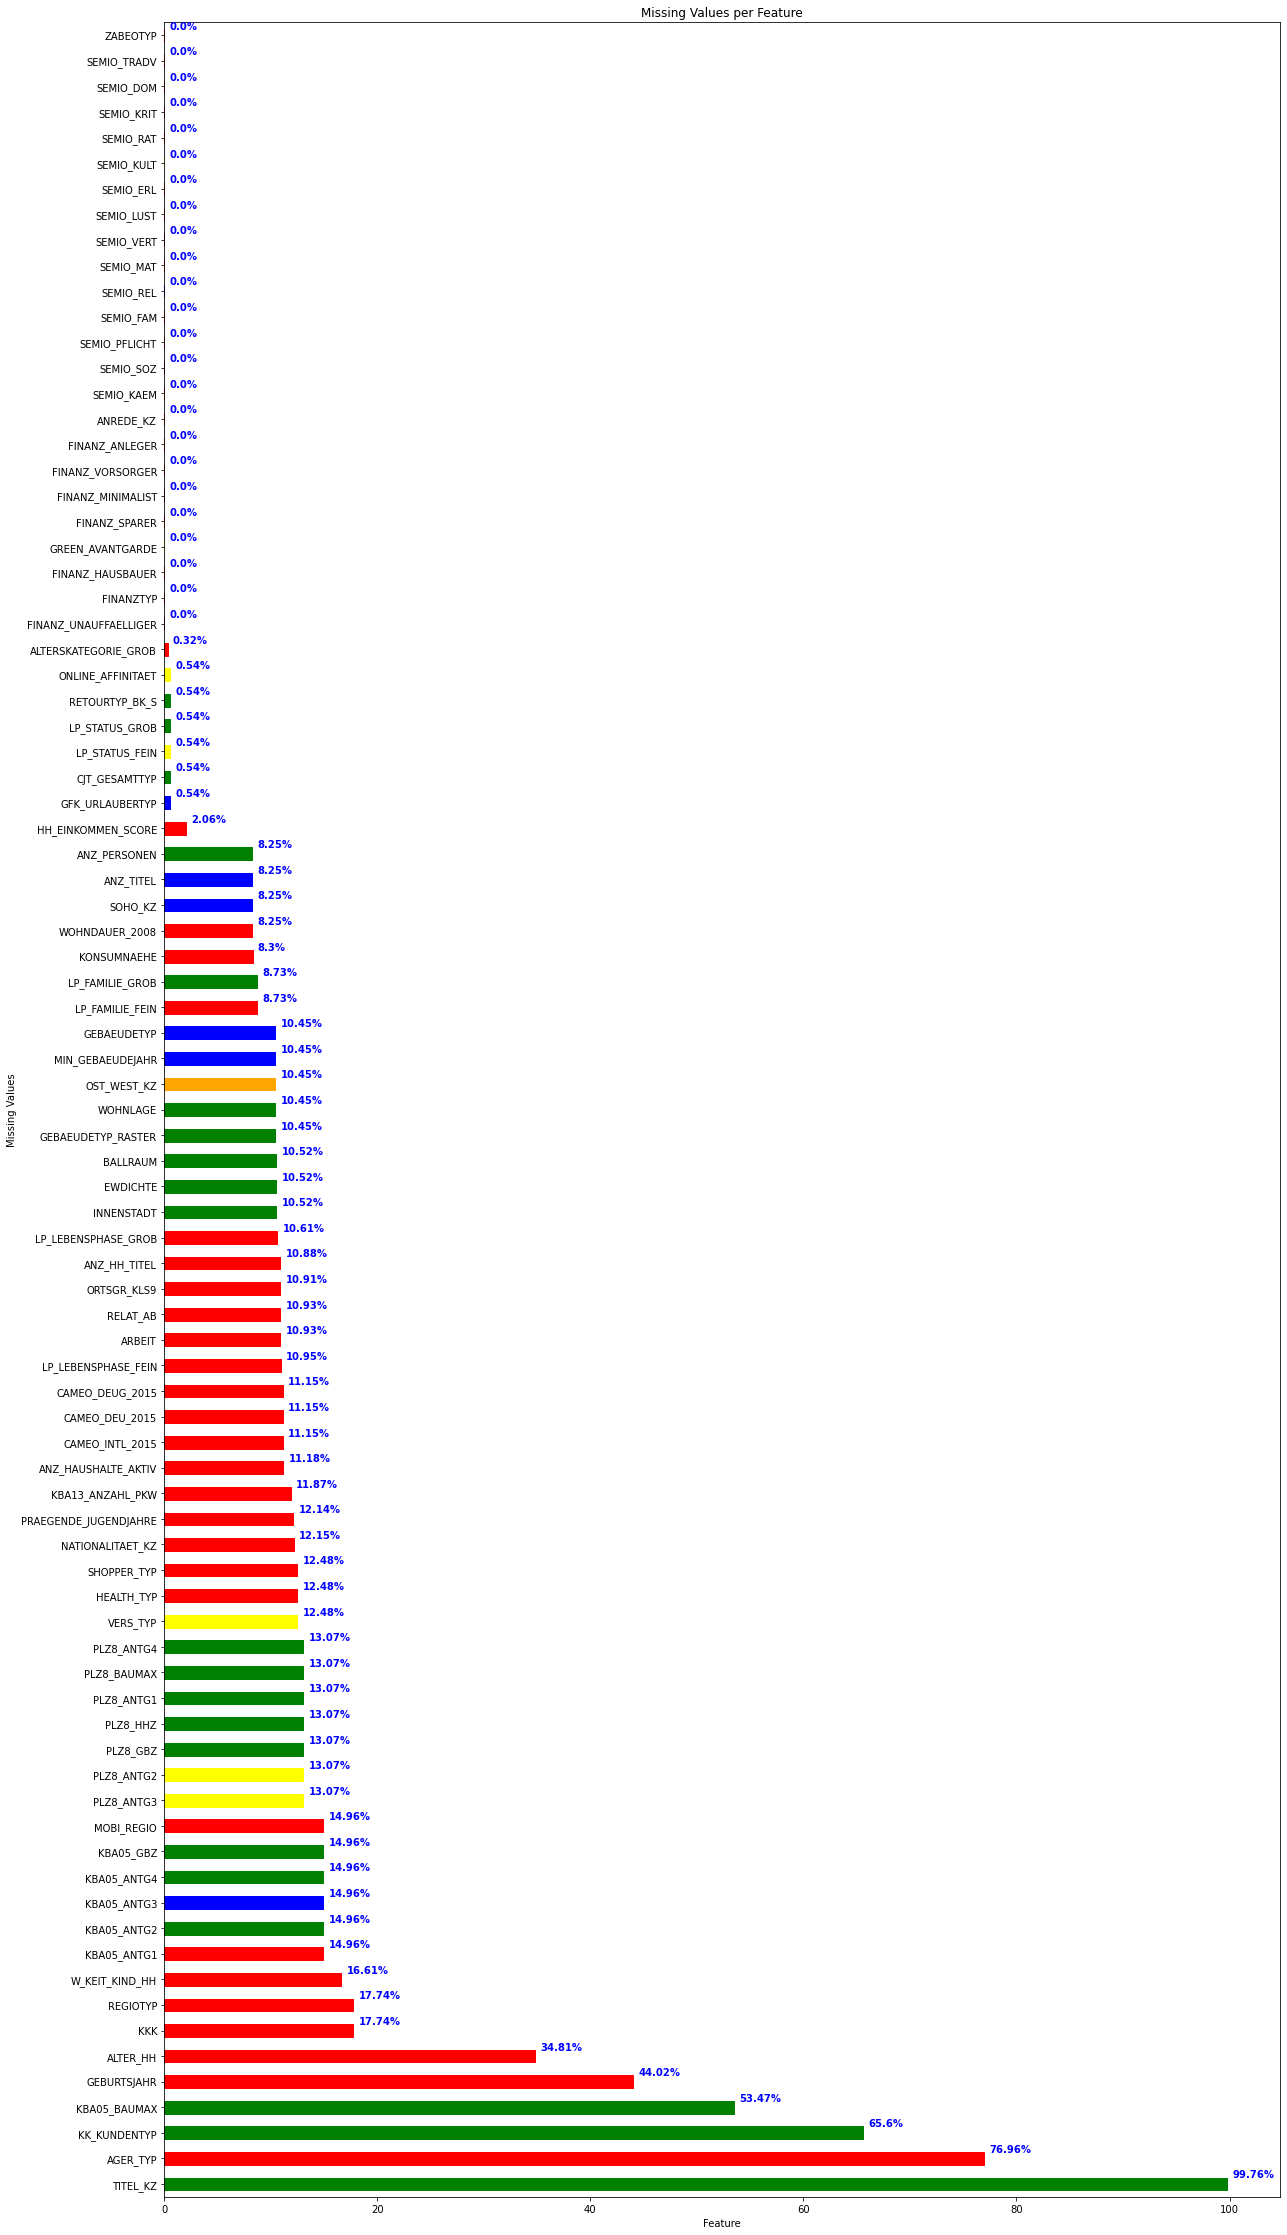

[99.75763587 76.9554353  65.59674873 53.46866827 44.02028229 34.81369941
 17.73566826 16.60508449 14.95970135 13.07363718 12.47681551 12.15355114
 12.13660809 11.87135402 11.17691347 11.14785222 10.95485856 10.92602172
 10.91468895 10.88484226 10.61150938 10.51815431 10.45251402 10.45172858
  8.72869917  8.2997371   8.24700046  2.05874862  0.54464605  0.32326438
  0.        ]


In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset using hist() 
# plot the missing values per feature
data = azdias.isnull().sum().sort_values(ascending=False)
data = data / azdias.shape[0] * 100
data.plot(kind='barh',figsize=(20,40))
ax = plt.gca()
plt.title('Missing Values per Feature')
plt.xlabel('Feature')
plt.ylabel('Missing Values')
# plot percent of missing values
for i, v in enumerate(data):
    ax.text(v + 0.5, i + .25, str(round(v, 2)) + '%', color='blue', fontweight='bold')

# plot each feature with information_level with corresponding random color
for i, v in enumerate(feat_info_full['type']):
    if v == 'ordinal':
        ax.get_children()[i].set_color('red')
        # color the background of the bar
    elif v == 'categorical':
        ax.get_children()[i].set_color('green')
    elif v == 'numeric':
        ax.get_children()[i].set_color('blue')
    elif v == 'mixed':
        ax.get_children()[i].set_color('yellow')
    elif v == 'interval':
        ax.get_children()[i].set_color('orange')
    elif v == 'ratio':
        ax.get_children()[i].set_color('purple')
    else:
        ax.get_children()[i].set_color('black')
plt.show()

# print data unique values
print(data.unique())


ordinal type features seem to take the lead when it comes down to the number of features that have missing values. The next most common type of feature is categorical. The rest of the features are a mix of binary and numerical features.

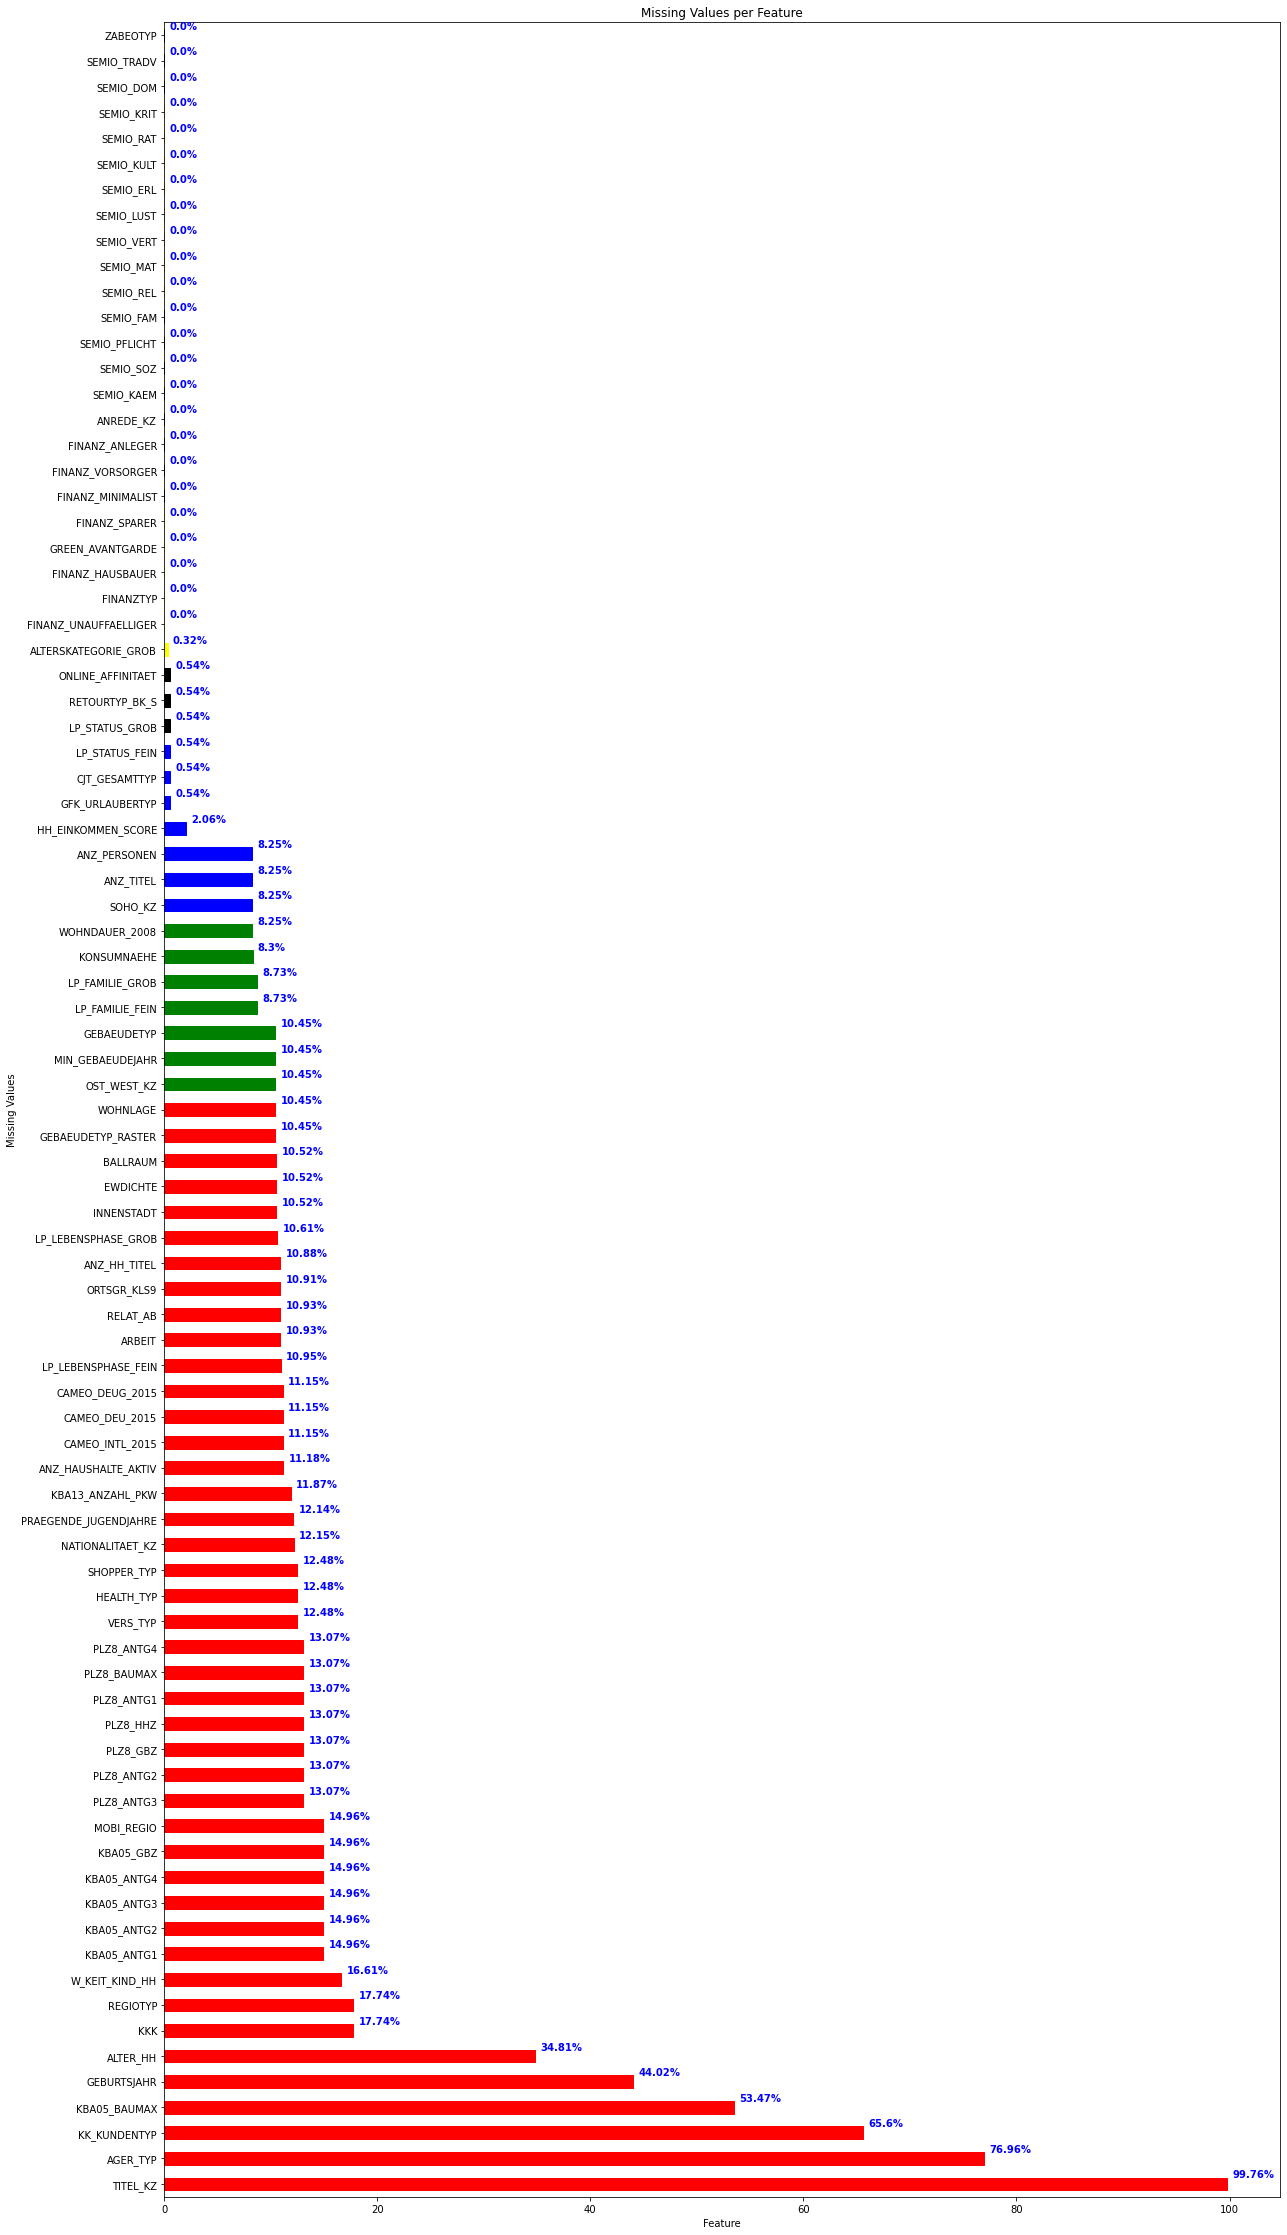

[99.75763587 76.9554353  65.59674873 53.46866827 44.02028229 34.81369941
 17.73566826 16.60508449 14.95970135 13.07363718 12.47681551 12.15355114
 12.13660809 11.87135402 11.17691347 11.14785222 10.95485856 10.92602172
 10.91468895 10.88484226 10.61150938 10.51815431 10.45251402 10.45172858
  8.72869917  8.2997371   8.24700046  2.05874862  0.54464605  0.32326438
  0.        ]


In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset using hist() 
# plot the missing values per feature
data = azdias.isnull().sum().sort_values(ascending=False)
data = data / azdias.shape[0] * 100
data.plot(kind='barh',figsize=(20,40))
ax = plt.gca()
plt.title('Missing Values per Feature')
plt.xlabel('Feature')
plt.ylabel('Missing Values')
# plot percent of missing values
for i, v in enumerate(data):
    ax.text(v + 0.5, i + .25, str(round(v, 2)) + '%', color='blue', fontweight='bold')

# plot each feature with information_level with corresponding random color
for i, v in enumerate(feat_info_full['information_level']):
    if v == 'person':
        ax.get_children()[i].set_color('red')
    elif v == 'household':
        ax.get_children()[i].set_color('green')
    elif v == 'building':
        ax.get_children()[i].set_color('blue')
    elif v == 'microcell_rr3':
        ax.get_children()[i].set_color('yellow')
    elif v == 'macrocell_plz8':
        ax.get_children()[i].set_color('orange')
    elif v == 'region_plz8':
        ax.get_children()[i].set_color('purple')
    elif v == 'microcell_rr1':
        ax.get_children()[i].set_color('black')
    elif v == 'region_rr4':
        ax.get_children()[i].set_color('pink')
    elif v == 'Postcode':
        ax.get_children()[i].set_color('brown')
    else:
        ax.get_children()[i].set_color('black')

plt.show()

# print data unique values
print(data.unique())

personal status features have the most missing values. The next most common feature is household followed by building and finally postcode.

In [9]:
# Investigate patterns in the amount of missing data in each column.
# How many columns have more than 20% missing data?
print('Number of columns with more than 20% missing data: {}'.format(data[data > 20].shape[0]))
# How many columns have between 5% and 20% missing data?
print('Number of columns with between 5% and 20% missing data: {}'.format(data[(data > 5) & (data <= 20)].shape[0]))
# How many columns have less than 5% missing data?
print('Number of columns with less than 5% missing data: {}'.format(data[data <= 5].shape[0]))
# How many rows have more than 20% missing data?
print('Number of rows with more than 20% missing data: {}'.format(azdias.isnull().sum(axis=1)[azdias.isnull().sum(axis=1) > 20].shape[0]))
# How many rows have between 5% and 20% missing data?
print('Number of rows with between 5% and 20% missing data: {}'.format(azdias.isnull().sum(axis=1)[(azdias.isnull().sum(axis=1) > 5) & (azdias.isnull().sum(axis=1) <= 20)].shape[0]))
# How many rows have less than 5% missing data?
print('Number of rows with less than 5% missing data: {}'.format(azdias.isnull().sum(axis=1)[azdias.isnull().sum(axis=1) <= 5].shape[0]))

Number of columns with more than 20% missing data: 6
Number of columns with between 5% and 20% missing data: 47
Number of columns with less than 5% missing data: 32
Number of rows with more than 20% missing data: 97526
Number of rows with between 5% and 20% missing data: 194452
Number of rows with less than 5% missing data: 599243


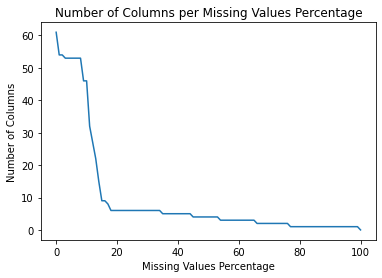

In [10]:
# plot number of columns per missing values percentage line plotting   
missing_values = [data[data > i].shape[0] for i in range(0, 101)]
plt.plot(range(0, 101), missing_values)
plt.title('Number of Columns per Missing Values Percentage')
plt.xlabel('Missing Values Percentage')
plt.ylabel('Number of Columns')
plt.show()


we can see that the sweet spot is around 20% missing data. We can also see that there are a few columns with a lot of missing data. We will remove these columns from the dataset.

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# drop columns with more than 20% missing data
azdias_dropped = azdias.drop(data[data > 20].index, axis=1)
azdias_dropped

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [12]:
# print name of deleted columns
deleted_columns = data[data > 20].index
print('Deleted columns: {}'.format(deleted_columns))
# drop those attributes from feat_info
deleted_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH']
feat_info = feat_info_full[~feat_info_full['attribute'].isin(deleted_columns)]


feat_info

Deleted columns: Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')


,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"{-1: nan, 0: nan, 9: nan}"
2,ANREDE_KZ,person,categorical,"{-1: nan, 0: nan}"
3,CJT_GESAMTTYP,person,categorical,{0: nan}
4,FINANZ_MINIMALIST,person,ordinal,{-1: nan}
5,FINANZ_SPARER,person,ordinal,{-1: nan}
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,{-1: nan}
81,PLZ8_GBZ,macrocell_plz8,ordinal,{-1: nan}
82,ARBEIT,community,ordinal,"{-1: nan, 9: nan}"
83,ORTSGR_KLS9,community,ordinal,"{-1: nan, 0: nan}"


In [13]:
# save the cleaned data
#azdias_dropped.to_csv('azdias_dropped.csv', index=False)


In [14]:
# load the cleaned data
#azdias_dropped = pd.read_csv('azdias_dropped.csv')

#### Discussion 1.1.2: Assess Missing Data in Each Column

we can group the features into three main groups judging by the number of missing fatures where the the first group has a number of missing features greater than 34% of the total number of features, the second group has a number of missing features between 5% and 20% and the third group has a number of missing features less than 5% to non. The first group has 6 features, the second group has 47 features and the third group has 32 features.

personal status features have the most missing values. The next most common feature is household followed by building and finally postcode.

ordinal type features seem to take the lead when it comes down to the number of features that have missing values. The next most common type of feature is categorical. The rest of the features are a mix of binary and numerical features.

removed columns are ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'] which all happened to be personal

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

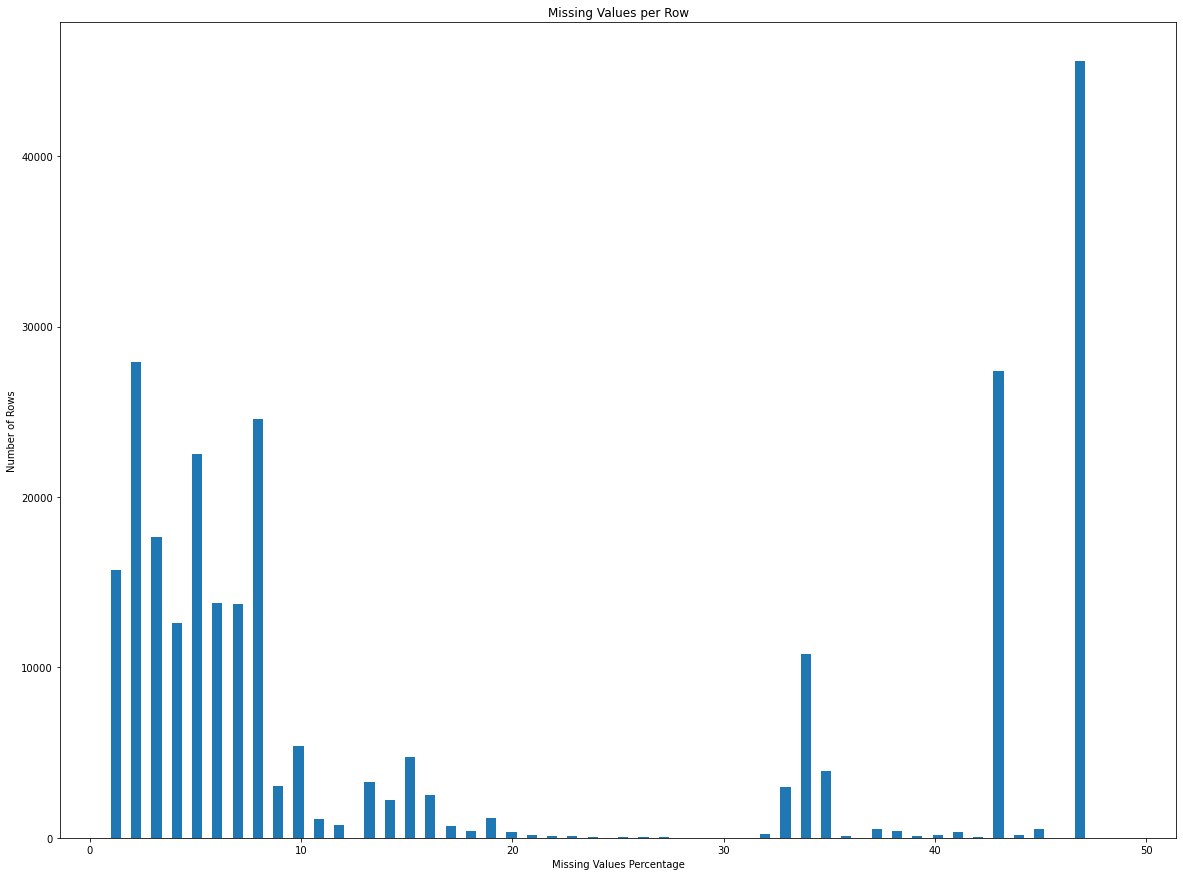

In [15]:
# How much data is missing in each row of the dataset?

missing = azdias_dropped.isnull().sum(axis=1)
missing = missing #/ azdias_dropped.shape[1] * 100
missing[missing>0].plot(kind='hist', bins=100, figsize=(20,15))
plt.title('Missing Values per Row')
plt.xlabel('Missing Values Percentage')
plt.ylabel('Number of Rows')
plt.show()




In [16]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
# The subset with fewer than 10% missing values will be used for most of the analysis and modeling.

# subset with fewer than 10% missing values
azdias_less_missing = azdias_dropped[azdias_dropped.isnull().sum(axis=1) <= azdias_dropped.shape[1] * 0.1 ]
print(azdias_less_missing.shape)
azdias_more_missing = azdias_dropped[azdias_dropped.isnull().sum(axis=1) > azdias_dropped.shape[1] * 0.1 ]
print(azdias_more_missing.shape)
azdias_no_missing = azdias_dropped[azdias_dropped.isnull().sum(axis=1) == 0]
print(azdias_no_missing.shape)

(747109, 79)
(144112, 79)
(623209, 79)


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


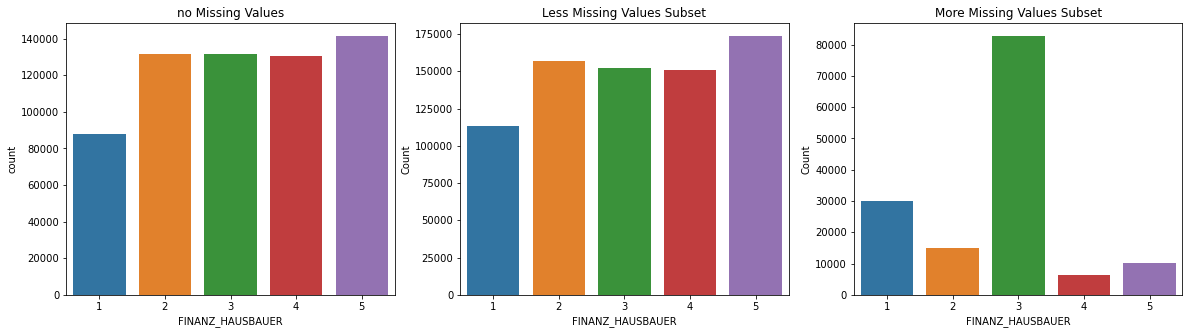

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


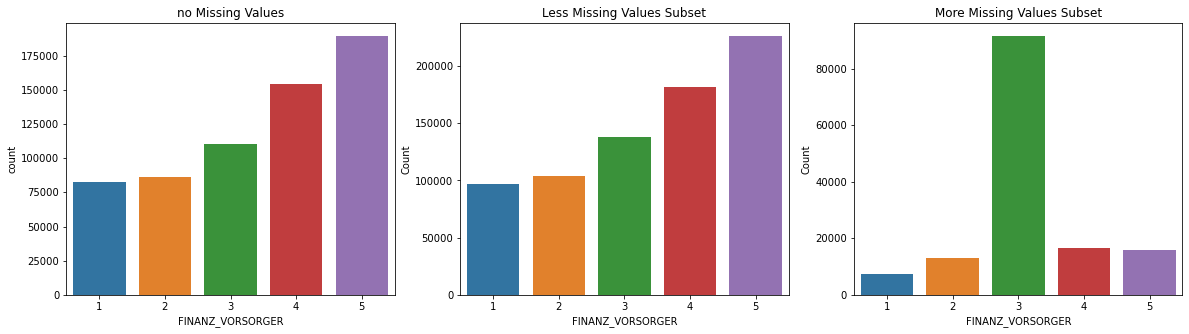

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


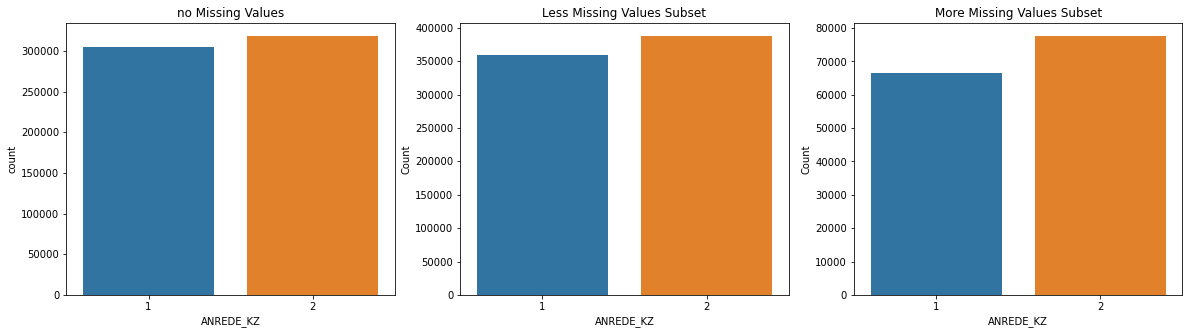

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


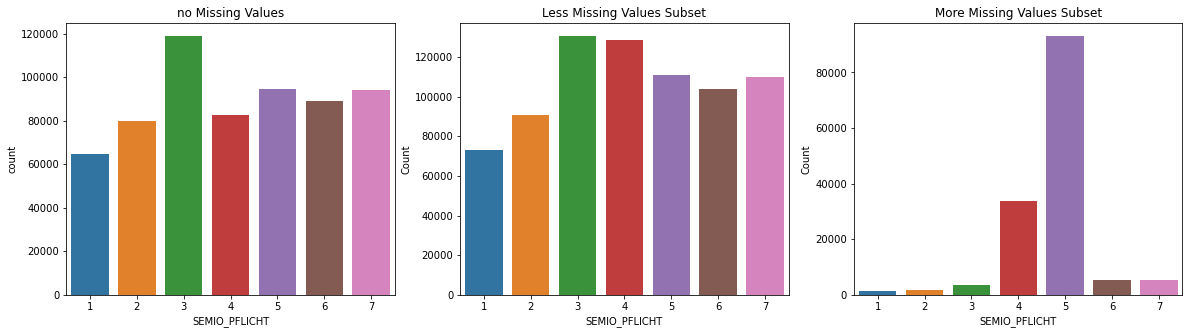

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


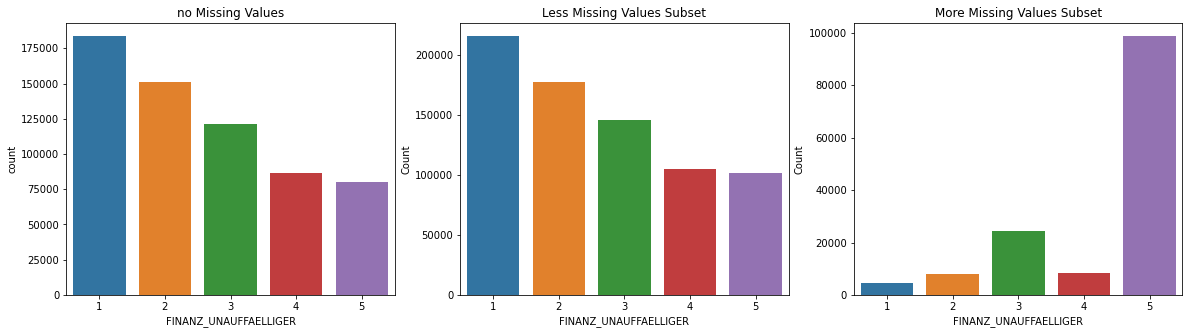

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


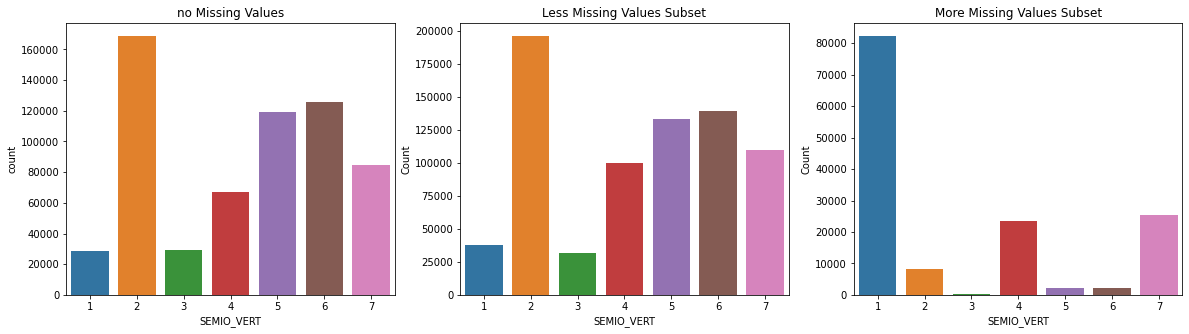

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


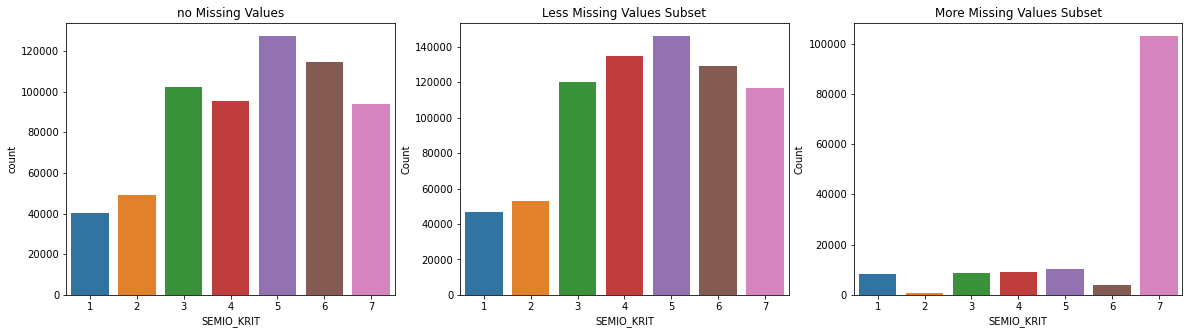

In [17]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

# features with zero missing values 
features = azdias_dropped.columns[azdias_dropped.isnull().sum() == 0]
#random pick 5 columns
random_five_features = np.random.choice(features, 7, replace=False)
# plot counterplot for random five features for both subsets
for feature in random_five_features:
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    sns.countplot(azdias_no_missing[feature])
    plt.title('no Missing Values')
    plt.subplot(1, 3, 2)
    sns.countplot(azdias_less_missing[feature])
    plt.title('Less Missing Values Subset')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.subplot(1, 3, 3)
    sns.countplot(azdias_more_missing[feature])
    plt.title('More Missing Values Subset')
    plt.xlabel(feature)
    plt.ylabel('Count')

    plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

lots of missing values are qualitatively different from data with few and no missing values, indicating that we should drop the rows with lots of missing values. because there seem to be hidden patterns in the data that we are not aware of, and leaving these patterns in the data will affect our analysis in ways we might fail to notice or understand. and due to the similarity of distribution of missing values between less and no missing values, we can safely leave the rows with less missing values. (threshold of 10 percent)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# which categorical variables have two possible values?
categorical = feat_info[feat_info['type'] == 'categorical']
categorical_df = azdias_less_missing[categorical['attribute']]
binary_features = (categorical_df.nunique() == 2).index[(categorical_df.nunique() == 2)]
print('Binary features: {}'.format(list(binary_features)))
# which categorical variables have more than two possible values?
multi_level_features = (categorical_df.nunique() > 2).index[(categorical_df.nunique() > 2)]
print('Multi-level features: {}'.format(list(multi_level_features)))

Binary features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [20]:
# inspect the binary features
for feature in binary_features:
    print('Feature: {}'.format(feature))
    print(categorical_df[feature].value_counts())
    


Feature: ANREDE_KZ
2    387686
1    359423
Name: ANREDE_KZ, dtype: int64
Feature: GREEN_AVANTGARDE
0    580191
1    166918
Name: GREEN_AVANTGARDE, dtype: int64
Feature: SOHO_KZ
0.0    740845
1.0      6264
Name: SOHO_KZ, dtype: int64
Feature: VERS_TYP
2.0    381818
1.0    340935
Name: VERS_TYP, dtype: int64
Feature: OST_WEST_KZ
W    587514
O    159595
Name: OST_WEST_KZ, dtype: int64


In [21]:
# OST_WEST_KZ is a binary feature, but it is encoded as a string. Re-encode it as a binary feature.
# categorical features need to be encoded as numeric values
# create a list of categorical features
categorical_features = list(multi_level_features)
categorical_features.append('OST_WEST_KZ')
categorical_features

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'OST_WEST_KZ']

In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
# re-encode necessary categorical features using OneHotEncoder
azdias_less_missing_categorical= pd.get_dummies(azdias_less_missing, columns=categorical_features, drop_first=True).reset_index(drop=True)
azdias_less_missing_categorical

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_W
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,0,1
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747104,3.0,2,1,4,2,5,4,4,0,3.0,...,0,0,0,0,0,0,0,0,0,1
747105,2.0,1,3,3,3,2,2,3,0,NaN,...,0,0,0,0,0,0,0,1,0,1
747106,2.0,2,2,4,2,5,4,3,0,1.0,...,0,0,0,0,0,0,0,0,0,1
747107,1.0,1,1,5,3,5,5,5,0,1.0,...,0,0,0,0,0,0,0,1,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features


found the binary variable that takes on non-numeric values and re-encoded it as a binary variable. the multi-level categoricals were encoded than dropped, than dropped the first dummy variable to avoid the trap of redundant information and reduces correlation among dummy variables. our dataframe now has it categorical variables encoded as binary variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
# print mixed type features
mixed_type_features = feat_info[feat_info['type'] == 'mixed']['attribute']
print('Mixed type features: {}'.format(list(mixed_type_features)))

Mixed type features: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [24]:
# there are 6 mixed variables
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# PRAEGENDE_JUGENDJAHRE: decade and movement
# decade: 40s, 50s, 60s, 70s, 80s, 90s
# movement: 0: Mainstream, 1: Avantgarde
# nation: E, W, E+W
# create a new column for decade
PRAEGENDE_JUGENDJAHRE_decade = {
    1: '40s - war years (Mainstream, E+W)',
    2: '40s - reconstruction years (Avantgarde, E+W)',
    3: '50s - economic miracle (Mainstream, E+W)',
    4: '50s - milk bar / Individualisation (Avantgarde, E+W)',
    5: '60s - economic miracle (Mainstream, E+W)',
    6: '60s - generation 68 / student protestors (Avantgarde, W)',
    7: '60s - opponents to the building of the Wall (Avantgarde, E)',
    8: '70s - family orientation (Mainstream, E+W)',
    9: '70s - peace movement (Avantgarde, E+W)',
    10: '80s - Generation Golf (Mainstream, W)',
    11: '80s - ecological awareness (Avantgarde, W)',
    12: '80s - FDJ / communist party youth organisation (Mainstream, E)',
    13: '80s - Swords into ploughshares (Avantgarde, E)',
    14: '90s - digital media kids (Mainstream, E+W)',
    15: '90s - ecological awareness (Avantgarde, E+W)'
}
decade_df = azdias_less_missing_categorical['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_decade)


In [25]:
decade_df = decade_df.str.split('\(|,|0s', expand=True)
decade_df.columns = ['decade', 'party','movement', 'nation']
decade_df = decade_df[['decade', 'movement']]
decade_df

,decade,movement
0,9,Mainstream
1,9,Avantgarde
2,7,Mainstream
3,7,Mainstream
4,5,Mainstream
...,...,...
747104,9,Mainstream
747105,8,Mainstream
747106,9,Mainstream
747107,9,Mainstream


In [26]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# CAMEO_INTL_2015: wealth and life stage
# wealth: 1: Wealthy Households, 2: Prosperous Households, 3: Comfortable Households, 4: Less Affluent Households
# life stage: 1: Pre-Family Couples & Singles, 2: Young Couples With Children, 3: Families With School Age Children, 4: Older Families & Mature Couples, 5: Elders In Retirement
# create a new column for wealth
cameo_intl_df = azdias_less_missing_categorical['CAMEO_INTL_2015'].str[0]
cameo_intl_df = pd.DataFrame(cameo_intl_df)
cameo_intl_df.columns = ['wealth']
cameo_intl_df['life_stage'] = azdias_less_missing_categorical['CAMEO_INTL_2015'].str[1]
cameo_intl_df

,wealth,life_stage
0,5,1
1,2,4
2,1,2
3,4,3
4,5,4
...,...,...
747104,4,1
747105,5,1
747106,2,4
747107,5,1


In [27]:
# one-hot encode the new features
decade_df = pd.get_dummies(decade_df, columns=['decade', 'movement'], drop_first=True)
cameo_intl_df = pd.get_dummies(cameo_intl_df, columns=['wealth', 'life_stage'], drop_first=True)
#concatenate the new features to the dataframe
azdias_less_missing_categorical = pd.concat([azdias_less_missing_categorical, decade_df, cameo_intl_df], axis=1)
#drop the original features
azdias_less_missing_categorical.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

In [28]:
azdias_less_missing_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747109 entries, 0 to 747108
Columns: 193 entries, ALTERSKATEGORIE_GROB to life_stage_5
dtypes: float64(41), int64(22), uint8(130)
memory usage: 451.7 MB


#### Discussion 1.2.2: Engineer Mixed-Type Features

created two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement. broke up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables. could not disentangle the other mixed-value features due to lack of levelsso they were just kept.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [29]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#original features were dropped, binary feature was properly encoded, categorical features were er-encoded,
# and mixed features were re-engineered. drop_first=True was used to avoid multicollinearity.


In [30]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [31]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i,feat in enumerate(df.columns):
        df[feat] = df[feat].replace(feat_info_full['missing_or_unknown'][i])
    # remove selected columns and rows, ...
    df = df[feat_info['attribute']] #dropping predetermined columns with missing values
    # drop rows with 10 percent missing values
    df =df[df.isnull().sum(axis=1) <= 0.1*df.shape[1]]
    # select, re-encode, and engineer column values.
    # Re-encode categorical variable(s) to be kept in the analysis. using same static features for consistency
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True).reset_index(drop=True)
    #re engineer mixed type features
    decade_df = df['PRAEGENDE_JUGENDJAHRE'].map(PRAEGENDE_JUGENDJAHRE_decade)
    decade_df = decade_df.str.split('\(|,|0s', expand=True)
    
    decade_df.columns = ['decade', 'party','movement', 'nation']
    decade_df = decade_df[['decade', 'movement']]


    cameo_intl_df = df['CAMEO_INTL_2015'].str[0]
    cameo_intl_df = pd.DataFrame(cameo_intl_df)
    cameo_intl_df.columns = ['wealth']
    cameo_intl_df['life_stage'] = df['CAMEO_INTL_2015'].str[1]


    decade_df = pd.get_dummies(decade_df, columns=['decade', 'movement'], drop_first=True)
    cameo_intl_df = pd.get_dummies(cameo_intl_df, columns=['wealth', 'life_stage'], drop_first=True)
    
    
    df = pd.concat([df, decade_df, cameo_intl_df], axis=1)
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# impute missing values
# impute missing values with most frequent value
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
azdias_less_missing_categorical_imputed = imputer.fit_transform(azdias_less_missing_categorical)
azdias_less_missing_categorical_imputed = pd.DataFrame(azdias_less_missing_categorical_imputed, columns=azdias_less_missing_categorical.columns)
azdias_less_missing_categorical_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747109 entries, 0 to 747108
Columns: 193 entries, ALTERSKATEGORIE_GROB to life_stage_5
dtypes: float64(193)
memory usage: 1.1 GB


In [33]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_less_missing_categorical_scaled = scaler.fit_transform(azdias_less_missing_categorical_imputed)
azdias_less_missing_categorical_scaled = pd.DataFrame(azdias_less_missing_categorical_scaled, columns=azdias_less_missing_categorical_imputed.columns)
azdias_less_missing_categorical_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747109 entries, 0 to 747108
Columns: 193 entries, ALTERSKATEGORIE_GROB to life_stage_5
dtypes: float64(193)
memory usage: 1.1 GB


### Discussion 2.1: Apply Feature Scaling

we performed imputation to replace all missing values. we used a StandardScaler instance to scale each feature to mean 0 and standard deviation 1. imputation was performed before scaling because:
- 1: there seems to be a pattern in the way data is missing that might add a bias that would skew the mean scale. 
- 2: imputing after scaling would make the imputed values have a different scale than the rest of the data.

however this way we presumably are forcing a topology that will be inferior to the one that would be found if we did not impute. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [34]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
azdias_pca = pca.fit_transform(azdias_less_missing_categorical_scaled)


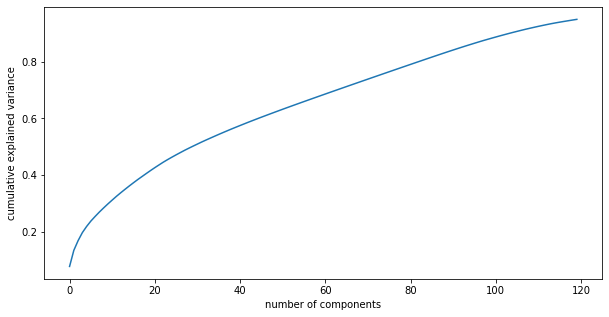

In [246]:
# Investigate the variance accounted for by each principal component.
azdias_pca_variance = pca.explained_variance_ratio_
# plot the variance of each principal component and the cumulative variance
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(azdias_pca_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


In [237]:
cs= np.cumsum(azdias_pca_variance)
sum(cs <= 0.95)

119

In [35]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=0.95)
azdias_pca = pca.fit_transform(azdias_less_missing_categorical_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

PCA was used to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. we decided to keep 119 components which help up perserve 95% of the variance and cut down the number of features by almost 40%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [340]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(full_dataset, pca): # this function maps all the components to the features
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = ['component_{}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1).T

pca_data = pca_results(azdias_less_missing_categorical_scaled, pca)
pca_data

# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
first_component = pca_data['component_1'].sort_values(ascending=False)
print(first_component.head(10))
# find information-level description of the first component
indexes= list(first_component.head(10).index)
feat_info[feat_info['attribute'].isin(indexes)]


PLZ8_ANTG3            0.1917
PLZ8_ANTG4            0.1858
PLZ8_BAUMAX           0.1818
HH_EINKOMMEN_SCORE    0.1808
ORTSGR_KLS9           0.1640
EWDICHTE              0.1619
wealth_5              0.1550
FINANZ_HAUSBAUER      0.1472
KBA05_ANTG4           0.1306
PLZ8_ANTG2            0.1304
Name: component_1, dtype: float64


,attribute,information_level,type,missing_or_unknown
9,FINANZ_HAUSBAUER,person,ordinal,{-1: nan}
46,HH_EINKOMMEN_SCORE,household,ordinal,"{-1: nan, 0: nan}"
63,KBA05_ANTG4,microcell_rr3,ordinal,{-1: nan}
67,EWDICHTE,postcode,ordinal,{-1: nan}
76,PLZ8_ANTG2,macrocell_plz8,ordinal,{-1: nan}
77,PLZ8_ANTG3,macrocell_plz8,ordinal,{-1: nan}
78,PLZ8_ANTG4,macrocell_plz8,ordinal,{-1: nan}
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"{-1: nan, 0: nan}"
83,ORTSGR_KLS9,community,ordinal,"{-1: nan, 0: nan}"


In [343]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
second_component = pca_data['component_2'].sort_values(ascending=False)
print(second_component.head(10))
# find information-level description of the second component
indexes= list(second_component.head(25).index)
feat_info[feat_info['attribute'].isin(indexes)]



ALTERSKATEGORIE_GROB    0.2336
FINANZ_VORSORGER        0.2214
ZABEOTYP_3              0.2006
SEMIO_ERL               0.1816
SEMIO_LUST              0.1649
RETOURTYP_BK_S          0.1601
W_KEIT_KIND_HH          0.1221
decade_6                0.1172
CJT_GESAMTTYP_2.0       0.1090
decade_5                0.1063
Name: component_2, dtype: float64


,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"{-1: nan, 0: nan, 9: nan}"
4,FINANZ_MINIMALIST,person,ordinal,{-1: nan}
6,FINANZ_VORSORGER,person,ordinal,{-1: nan}
9,FINANZ_HAUSBAUER,person,ordinal,{-1: nan}
23,RETOURTYP_BK_S,person,ordinal,{0: nan}
29,SEMIO_LUST,person,ordinal,"{-1: nan, 9: nan}"
30,SEMIO_ERL,person,ordinal,"{-1: nan, 9: nan}"
33,SEMIO_KRIT,person,ordinal,"{-1: nan, 9: nan}"
35,SEMIO_KAEM,person,ordinal,"{-1: nan, 9: nan}"
48,W_KEIT_KIND_HH,household,ordinal,"{-1: nan, 0: nan}"


In [345]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_component = pca_data['component_3'].sort_values(ascending=False)
print(third_component.head(10))
# find information-level description of the third component
indexes= list(third_component.head(15).index)
feat_info[feat_info['attribute'].isin(indexes)]


SEMIO_VERT           0.3263
SEMIO_FAM            0.2595
SEMIO_SOZ            0.2593
SEMIO_KULT           0.2481
FINANZ_MINIMALIST    0.1426
FINANZTYP_5          0.1421
SEMIO_REL            0.1147
GREEN_AVANTGARDE     0.1034
SEMIO_MAT            0.0867
RETOURTYP_BK_S       0.0791
Name: component_3, dtype: float64


,attribute,information_level,type,missing_or_unknown
4,FINANZ_MINIMALIST,person,ordinal,{-1: nan}
13,GREEN_AVANTGARDE,person,categorical,{}
23,RETOURTYP_BK_S,person,ordinal,{0: nan}
24,SEMIO_SOZ,person,ordinal,"{-1: nan, 9: nan}"
25,SEMIO_FAM,person,ordinal,"{-1: nan, 9: nan}"
26,SEMIO_REL,person,ordinal,"{-1: nan, 9: nan}"
27,SEMIO_MAT,person,ordinal,"{-1: nan, 9: nan}"
28,SEMIO_VERT,person,ordinal,"{-1: nan, 9: nan}"
31,SEMIO_KULT,person,ordinal,"{-1: nan, 9: nan}"
67,EWDICHTE,postcode,ordinal,{-1: nan}


### Discussion 2.3: Interpret Principal Components


it seems like the first component is a measure of the persons macro-cell features. the second component is a measure of the persons financial habits, and the third component is a measure of the personality and cultural/ideological direction.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...  
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

azdias_pca_df = pd.DataFrame(azdias_pca)
small_azdias_pca = azdias_pca_df.sample(frac=0.2, random_state=42)
cluster_counts = [2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16,17,18,19,20]
inertias = []
silhouette_scores = []

for cluster_count in cluster_counts:
    print('cluster count: ', cluster_count)
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=cluster_count, random_state=42, n_jobs=-1)
    kmeans.fit(azdias_pca_df)
    # compute the average within-cluster distances.
    print('inertia: ', kmeans.inertia_)
    inertias.append(kmeans.inertia_)
    ss = kmeans.score(azdias_pca_df, kmeans.labels_)
    print('silhouette score: ', ss)
    silhouette_scores.append(ss)
    print('-----------------')

    
    

    

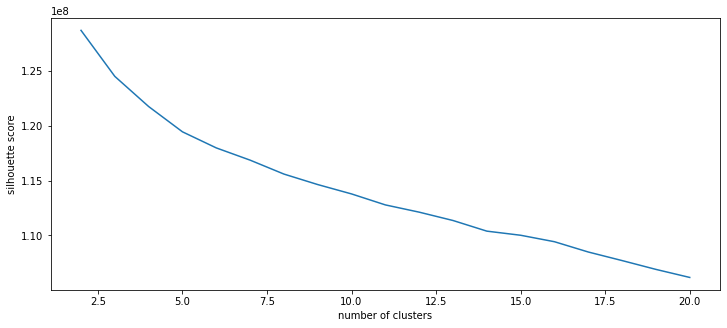

In [293]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12,5))
plt.plot(cluster_counts, inertias)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.show()
# 8 seems to be the best number of clusters

In [107]:
# import knee locator to find the best number of clusters
from kneed import KneeLocator
from sklearn.cluster import KMeans
kl = KneeLocator(cluster_counts, inertias, curve='convex', direction='decreasing')
kl.elbow

# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters= kl.elbow, random_state=42, n_jobs=-1)
kmeans.fit(azdias_pca)
azdias_less_missing_categorical_scaled['cluster'] = kmeans.labels_
azdias_less_missing_categorical_scaled['cluster'].value_counts()


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


13    81217
0     71218
2     68516
14    64308
10    55877
8     55640
9     52765
4     50141
7     48956
15    43281
6     35650
3     35078
1     33239
11    30817
12    14734
5      5672
Name: cluster, dtype: int64

### Discussion 3.1: Apply Clustering to General Population
i have decided to use automatic cluster count selection. i have used the elbow method to select the number of clusters. the elbow method is a method in the kneed package that help mathimatically select the number of clusters.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [94]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [95]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_ready = clean_data(customers)
customers_ready 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,decade_9,movement_Mainstream,wealth_2,wealth_3,wealth_4,wealth_5,life_stage_2,life_stage_3,life_stage_4,life_stage_5
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,0,1,0,0
1,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,1,0,0,0,0,1,0
2,4.0,1,5,1,5,2,1,2,0,2.0,...,0,1,1,0,0,0,0,0,1,0
3,3.0,1,3,1,4,4,5,2,0,3.0,...,0,1,0,0,1,0,0,0,0,0
4,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133422,2.0,2,2,1,5,1,2,5,0,2.0,...,0,1,0,0,0,0,0,0,1,0
133423,3.0,1,5,1,5,1,1,2,1,3.0,...,0,0,0,0,0,0,0,0,1,0
133424,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,1,0,0,0,0,0,1,0
133425,3.0,2,2,1,5,1,2,5,0,2.0,...,0,1,1,0,0,0,0,0,1,0


In [96]:
# find differences between the two datasets
for column in azdias_less_missing_categorical.columns:
    if column not in customers_ready.columns:
        missing_column = column
        print(column)

GEBAEUDETYP_5.0


In [97]:
# impute the missing data with the mean
imputer = SimpleImputer(strategy='most_frequent')
customers_ready_imputed = imputer.fit_transform(customers_ready)
customers_ready_imputed = pd.DataFrame(customers_ready_imputed, columns=customers_ready.columns)
customers_ready_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133427 entries, 0 to 133426
Columns: 192 entries, ALTERSKATEGORIE_GROB to life_stage_5
dtypes: float64(192)
memory usage: 195.4 MB


In [98]:
# add the missing column with 0
customers_ready_imputed[missing_column] = 0
customers_ready_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133427 entries, 0 to 133426
Columns: 193 entries, ALTERSKATEGORIE_GROB to GEBAEUDETYP_5.0
dtypes: float64(192), int64(1)
memory usage: 196.5 MB


In [99]:
# scale the data
customers_ready_imputed_scaled = scaler.transform(customers_ready_imputed)

In [100]:
# apply pca
customers_ready_imputed_scaled_pca = pca.transform(customers_ready_imputed_scaled)

In [101]:
# cluster the data
customers_ready_imputed_scaled = pd.DataFrame(customers_ready_imputed_scaled, columns=customers_ready_imputed.columns)
customers_ready_imputed_scaled['cluster'] = kmeans.predict(customers_ready_imputed_scaled_pca)
customers_ready_imputed_scaled['cluster'].value_counts()

5     100329
13      8225
11      7155
6       6329
1       3652
14      1951
2       1935
8       1287
15       691
4        656
9        305
12       303
0        297
10       263
3         36
7         13
Name: cluster, dtype: int64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

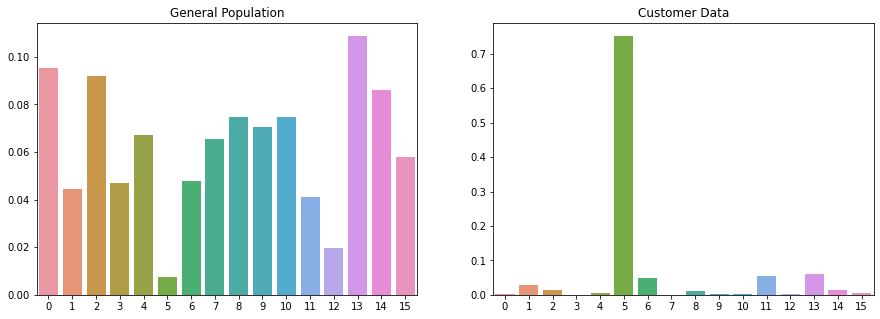

In [102]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_data_cluster_proportion = azdias_less_missing_categorical_scaled['cluster'].value_counts(normalize=True)
customer_data_cluster_proportion = customers_ready_imputed_scaled['cluster'].value_counts(normalize=True)
# subplots
plt.figure( figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=general_data_cluster_proportion.index, y=general_data_cluster_proportion.values)
plt.title('General Population')
plt.subplot(1,2,2)
sns.barplot(x=customer_data_cluster_proportion.index, y=customer_data_cluster_proportion.values)
plt.title('Customer Data')


plt.show()

In [115]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

overrepresented_cluster = customer_data_cluster_proportion.idxmax()
# use inverse transform to get the original data
centroid = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[overrepresented_cluster]))
centroid = pd.Series(centroid, index=customers_ready_imputed.columns)
centroid.head(10)

ALTERSKATEGORIE_GROB     3.489723
ANREDE_KZ                1.710385
FINANZ_MINIMALIST        2.613787
FINANZ_SPARER            1.537104
FINANZ_VORSORGER         4.382069
FINANZ_ANLEGER           1.687276
FINANZ_UNAUFFAELLIGER    1.708542
FINANZ_HAUSBAUER         4.595223
GREEN_AVANTGARDE         0.073461
HEALTH_TYP               1.921161
dtype: float64

In [114]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented_cluster = customer_data_cluster_proportion.idxmin()
# use inverse transform to get the original data
centroid1 = kmeans.cluster_centers_[underrepresented_cluster]
centroid1 = pca.inverse_transform(centroid1)
centroid1 = scaler.inverse_transform(centroid1)
centroid1 = pd.Series(centroid1, index=customers_ready_imputed.columns)
centroid1.head(10)

ALTERSKATEGORIE_GROB     3.203118
ANREDE_KZ                1.466904
FINANZ_MINIMALIST        2.708602
FINANZ_SPARER            2.377325
FINANZ_VORSORGER         3.956463
FINANZ_ANLEGER           2.276761
FINANZ_UNAUFFAELLIGER    1.820777
FINANZ_HAUSBAUER         3.827329
GREEN_AVANTGARDE         0.020033
HEALTH_TYP               2.377374
dtype: float64

In [120]:
diff = pd.DataFrame(centroid - centroid1, columns=['diff'])
df = pd.concat([centroid, centroid1, diff], axis=1)
df.sort_values(by='diff', ascending=False)

,0,1,diff
KBA13_ANZAHL_PKW,593.507854,480.980230,112.527624
ANZ_HAUSHALTE_AKTIV,50.495403,19.300682,31.194721
SEMIO_LUST,5.975857,4.841126,1.134732
GEBAEUDETYP_5.0,0.990204,-0.001009,0.991213
OST_WEST_KZ_W,0.988513,0.000268,0.988245
...,...,...,...
SEMIO_REL,2.680717,3.497547,-0.816830
FINANZ_SPARER,1.537104,2.377325,-0.840221
SEMIO_FAM,3.255849,4.143301,-0.887452
LP_LEBENSPHASE_FEIN,9.055563,10.201717,-1.146154


### Discussion 3.3: Compare Customer Data to Demographics Data

top five differences between the underrepresented and overrepresented clusters
- 1: the overrepresented seem to have on average of 112 more cars in the PLZ8 region. KBA13_ANZAHL_PKW
- 2: 31 more average households in the building (bigger complexes) ANZ_HAUSHALTE_AKTIV
- 3: Low vs Average affinity sensual-mindedness SEMIO_LUST
- 4: overrepresented building in West germany OST_WEST_KZ_W
- 5: overrepresented have very high cultural minded afinity compared to average of underrepresented SEMIO_KULT


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.